In [1]:
import pandas as pd
import numpy as np
max_timesteps = 24 # 24 hours

# Reading & Preprocessing

In [2]:
df = pd.read_csv("../transactions/reputable_transactions_H.csv")

In [3]:
opcode_embeddings = pd.read_csv("opcode_embeddings.csv")
df['address'] = df['address'].str.lower()
opcode_embeddings['address'] = opcode_embeddings['address'].str.lower()
opcode_embeddings = opcode_embeddings[opcode_embeddings['address'].isin(df['address'])]

# Select only the continuous variables from the provided columns
continuous_cols = df.drop(columns=['address', 'avg_min_between_received_tnx_missing',
                                   'avg_min_between_sent_tnx_missing', 'timeStamp'],
                                   axis=1).columns

# Now, remove outliers from only the continuous variables
for col in continuous_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Reset index and display the cleaned DataFrame
df.reset_index(drop=True, inplace=True)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[df.drop(columns=["address", "timeStamp"]).columns] = scaler.fit_transform(df[df.drop(columns=["address", "timeStamp"]).columns])


In [4]:
df = df.merge(opcode_embeddings, on='address', how='left')
del opcode_embeddings

In [5]:
df['address'].nunique()

967

In [6]:
from sklearn.model_selection import train_test_split

unique_addresses_reputable = df['address'].unique()

# Step 2: Split the contract addresses into 70% for training and 30% for testing
train_addresses, test_addresses = train_test_split(unique_addresses_reputable, test_size=0.3, random_state=42, shuffle=True)

# Step 3: Create X_train by filtering the original dataframe for the training addresses
X_train_reputable = df[df['address'].isin(train_addresses)]

# Step 4: Create X_test by combining the transactions of the 30% test reputable addresses with all illicit contracts
X_test_reputable = df[df['address'].isin(test_addresses)]

X_train_reputable.to_csv("reputable_train.csv", index=False)
X_test_reputable.to_csv("reputable_test.csv", index=False)

In [3]:
df = pd.read_csv("reputable_test.csv")

# CNN-Based Autoencoder

## Architecture

In [7]:
df.columns

Index(['address', 'timeStamp', 'transaction_count_sent', 'total_value_sent',
       'avg_value_sent', 'min_value_sent', 'max_value_sent', 'gas_sum_sent',
       'gas_mean_sent', 'gasPrice_sum_sent', 'gasUsed_sum_sent',
       'gasUsed_mean_sent', 'error_count_sent',
       'unique_contracts_interacted_with_sent', 'avg_min_between_sent_tnx',
       'transaction_count_received', 'total_value_received',
       'avg_value_received', 'min_value_received', 'max_value_received',
       'gas_sum_received', 'gas_mean_received', 'gasPrice_sum_received',
       'gasUsed_sum_received', 'gasUsed_mean_received', 'error_count_received',
       'unique_contracts_interacted_with_received',
       'avg_min_between_received_tnx', 'time_diff_between_first_and_last',
       'avg_min_between_sent_tnx_missing',
       'avg_min_between_received_tnx_missing', '0', '1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', '24',

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Dropout, ZeroPadding1D
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import kerastuner as kt

# Define basic mean squared error loss
def mse(y_true, y_pred):
    return tf.keras.losses.MeanSquaredError()(y_true, y_pred)
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import kerastuner as kt
# Define the CAE model with extended hyperparameters
class CAEHyperModel(kt.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        input_seq = Input(shape=self.input_shape)

        # Encoder
        x = Conv1D(filters=hp.Int('filters_1', min_value=16, max_value=64, step=16), 
                   kernel_size=hp.Choice('kernel_size_1', values=[3, 5]), 
                   activation=hp.Choice('activation', values=['relu', 'tanh']), 
                   padding='same',
                   kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_reg_1', min_value=0, max_value=0.1, step=0.01)))(input_seq)
        x = MaxPooling1D(pool_size=hp.Choice('pool_size_1', values=[2, 4]), padding='same')(x)
        x = Dropout(hp.Float('dropout_1', min_value=0, max_value=0.5, step=0.1))(x)
        x = Conv1D(filters=hp.Int('filters_2', min_value=8, max_value=32, step=8), 
                   kernel_size=hp.Choice('kernel_size_2', values=[3, 5]), 
                   activation=hp.Choice('activation', values=['relu', 'tanh']), 
                   padding='same',
                   kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_reg_2', min_value=0, max_value=0.1, step=0.01)))(x)
        encoded = MaxPooling1D(pool_size=hp.Choice('pool_size_2', values=[2, 4]), padding='same')(x)

        # Decoder
        x = Conv1D(filters=hp.Int('filters_2', min_value=8, max_value=32, step=8), 
                   kernel_size=hp.Choice('kernel_size_2', values=[3, 5]), 
                   activation=hp.Choice('activation', values=['relu', 'tanh']), 
                   padding='same')(encoded)
        x = UpSampling1D(size=hp.Choice('up_sampling_size_1', values=[2, 4]))(x)
        x = Dropout(hp.Float('dropout_2', min_value=0, max_value=0.5, step=0.1))(x)
        x = Conv1D(filters=hp.Int('filters_1', min_value=16, max_value=64, step=16), 
                   kernel_size=hp.Choice('kernel_size_1', values=[3, 5]), 
                   activation=hp.Choice('activation', values=['relu', 'tanh']), 
                   padding='same')(x)
        x = UpSampling1D(size=hp.Choice('up_sampling_size_2', values=[2, 4]))(x)
        
        # Adjust the final output to match the original input sequence length
        x = x[:, :max_timesteps, :]
        decoded = Conv1D(self.input_shape[1], kernel_size=3, activation='sigmoid', padding='same')(x)

        # decoded = decoded[:, :self.input_shape[0], :]  # Ensure the output has the same length as the input
        model = Model(input_seq, decoded)
        model.compile(optimizer=tf.keras.optimizers.Adam(
                          hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                      loss='mse')
        return model

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))  # Ensure the output is a float

lr_scheduler = LearningRateScheduler(scheduler)

2024-10-06 15:06:08.759608: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-06 15:06:08.856771: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 15:06:08.933810: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 15:06:08.955365: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-06 15:06:09.029943: I tensorflow/core/platform/cpu_feature_guar

In [4]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import cudf
import cupy as cp
from cudf.core.column import as_column
from cupy import pad

def prepare_data_gpu(df, max_timesteps):
    # Convert pandas DataFrame to cuDF DataFrame
    df_cudf = cudf.from_pandas(df)

    # Group transactions by contract address
    grouped = df_cudf.groupby('address')

    # Prepare sequences using cuDF and cuPy
    sequences = []
    addresses = []
    
    # Iterate over grouped addresses
    for address, group in grouped:
        # Drop unwanted columns and convert to cuPy array
        sequence = cp.asarray(group.drop(columns=["address", "timeStamp"]).to_pandas().values)
        
        # Handle long sequences by splitting into multiple segments
        if len(sequence) > max_timesteps:
            # Split sequence into segments of max_timesteps
            num_segments = int(cp.ceil(len(sequence) / max_timesteps))
            for i in range(num_segments):
                sub_sequence = sequence[i * max_timesteps: (i + 1) * max_timesteps]
                sequences.append(sub_sequence)
                addresses.append(address)
        else:
            sequences.append(sequence)
            addresses.append(address)

    # Pad sequences to ensure uniform length using list comprehension directly
    X_padded = cp.array([cp.pad(seq, ((0, max_timesteps - len(seq)), (0, 0)), mode='constant') if len(seq) < max_timesteps else seq for seq in sequences])

    return X_padded, addresses

# Set a reasonable max_timesteps value
max_timesteps = 24  # Adjust based on your data distribution analysis

# Prepare data without losing transactions using GPU acceleration
X_rep, addresses_rep = prepare_data_gpu(df, max_timesteps)

In [6]:
X_rep.shape

(25126, 24, 79)

In [7]:
import cupy as cp
cp.save("X_rep.npy", X_rep)
# X_rep 

## Model Training

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import keras_tuner as kt
import numpy as np
import cupy as cp
# Function to perform K-Fold Cross-Validation and Batch size tuning
from sklearn.model_selection import TimeSeriesSplit

def train_and_evaluate(max_timesteps, batch_sizes=[16, 32, 64]):
    histories = {}
    tuning_results = []  # Store tuning results

    X_rep_np = cp.load("X_rep.npy").get()

    for batch_size in batch_sizes:
        fold_no = 1
        
        # Reinitialize the split generator for each batch size
        tscv = TimeSeriesSplit(n_splits=5)
        split_generator = tscv.split(X_rep_np)
        
        for train_index, val_index in split_generator:
            X_train, X_val = X_rep_np[train_index], X_rep_np[val_index]

            # Define the model
            hypermodel = CAEHyperModel(input_shape=(max_timesteps, X_rep_np.shape[2]))
            tuner = kt.RandomSearch(
                hypermodel,
                objective='val_loss',
                max_trials=5,
                executions_per_trial=1,
                directory='tuner_dir',
                project_name=f'cae_tuning_opcode_tnx_{batch_size}'
            )

            # Perform hyperparameter search WITH the LearningRateScheduler
            tuner.search(X_train, X_train,
                         epochs=30,
                         batch_size=batch_size,
                         validation_data=(X_val, X_val),
                         callbacks=[lr_scheduler])  # Apply the learning rate scheduler during search

            # Get the best hyperparameters and store them
            best_hp = tuner.oracle.get_best_trials(1)[0].hyperparameters.values

            best_trial = tuner.oracle.get_best_trials(1)[0]
            val_loss_history = best_trial.metrics.get_history('val_loss')
            best_val_loss = val_loss_history[-1]  # Get the last validation loss value (best)

            # Append the results including best validation loss
            tuning_results.append({
                'batch_size': batch_size,
                'fold': fold_no,
                'best_filters_1': best_hp['filters_1'],
                'best_filters_2': best_hp['filters_2'],
                'learning_rate': best_hp['learning_rate'],
                'activation': best_hp['activation'], 
                'kernel_size_1': best_hp['kernel_size_1'],
                'kernel_size_2': best_hp['kernel_size_2'],
                'l2_reg_1': best_hp['l2_reg_1'],
                'l2_reg_2': best_hp['l2_reg_2'],
                'pool_size_1': best_hp['pool_size_1'],
                'pool_size_2': best_hp['pool_size_2'],
                'dropout_1': best_hp['dropout_1'],
                'dropout_2': best_hp['dropout_2'],
                'up_sampling_size_1': best_hp['up_sampling_size_1'],
                'up_sampling_size_2': best_hp['up_sampling_size_2'],
                'val_loss': best_val_loss
            })

            # Get the best model
            best_model = tuner.get_best_models(num_models=1)[0]
            best_model.save(f"cae_tnx_opcode_{batch_size}.keras")

            # Now fit the best model with the LearningRateScheduler
            history = best_model.fit(
                X_train, X_train,
                epochs=30,
                batch_size=batch_size,
                validation_data=(X_val, X_val),
                callbacks=[lr_scheduler]  # Continue using the scheduler after finding the best model
            )

            # Initialize histories for the current batch size if not done already
            if batch_size not in histories:
                histories[batch_size] = {'train_loss': [], 'val_loss': []}

            # Collect the loss histories for the current fold
            histories[batch_size]['train_loss'].append(history.history['loss'])
            histories[batch_size]['val_loss'].append(history.history['val_loss'])

            fold_no += 1

    # Plot training and validation loss for different batch sizes
    plt.figure(figsize=(12, 6))
    for batch_size in batch_sizes:
        # Safeguard against missing data
        if batch_size in histories:
            train_loss_avg = np.mean(histories[batch_size]['train_loss'], axis=0)
            val_loss_avg = np.mean(histories[batch_size]['val_loss'], axis=0)
            
            # Create a new figure for each batch size
            plt.figure(figsize=(8, 5))
            plt.plot(train_loss_avg, label=f'Training Loss (batch={batch_size})')
            plt.plot(val_loss_avg, '--', label=f'Validation Loss (batch={batch_size})')
            
            # Set plot title and labels
            plt.title(f'Training and Validation Loss for Batch Size {batch_size}')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            
            # Show the plot
            plt.show()
    
    # Hyperparameter tuning results as a DataFrame
    tuning_df = pd.DataFrame(tuning_results)
    
    # Print the hyperparameter tuning results
    print("\nHyperparameter Tuning Results:")
    print(tuning_df)

    # Save the tuning results to a CSV for later analysis
    tuning_df.to_csv('hyperparameter_tuning_results_opcode_tnx.csv', index=False)

    return best_model, tuning_df

Trial 5 Complete [00h 00m 17s]
val_loss: 0.008102517575025558

Best val_loss So Far: 0.006751386448740959
Total elapsed time: 00h 01m 12s
Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0073 - val_loss: 0.0068 - learning_rate: 0.0024
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069 - val_loss: 0.0068 - learning_rate: 0.0024
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069 - val_loss: 0.0068 - learning_rate: 0.0024
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0068 - learning_rate: 0.0024
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0067 - learning_rate: 0.0024
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069 - val_loss: 0.0068 - learning_rate: 0.0024
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0067 - learning_rate: 0.0024
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0067 - learning_rate: 0.00

<Figure size 1200x600 with 0 Axes>

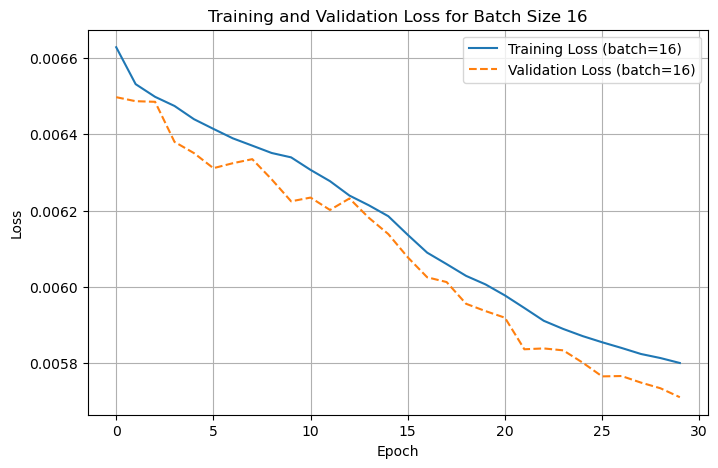

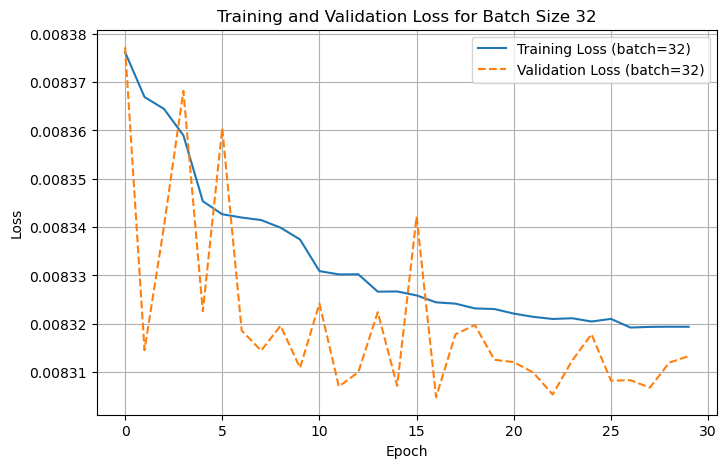

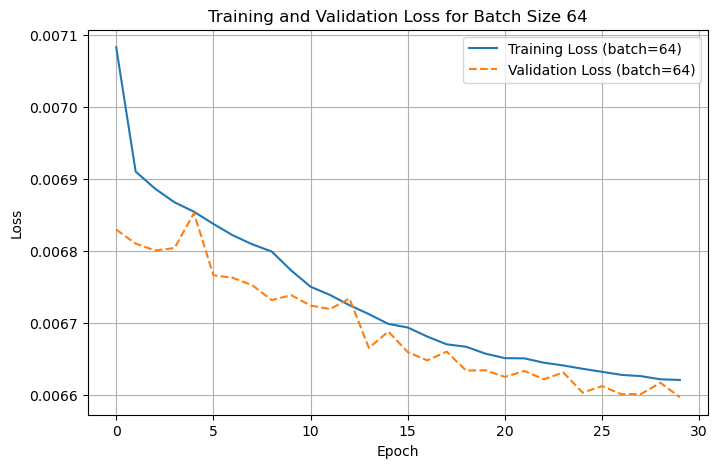


Hyperparameter Tuning Results:
    batch_size  fold  best_filters_1  best_filters_2  learning_rate  \
0           16     1              48              24       0.001207   
1           16     2              48              24       0.001207   
2           16     3              48              24       0.001207   
3           16     4              48              24       0.001207   
4           16     5              48              24       0.001207   
5           32     1              48              16       0.001632   
6           32     2              48              16       0.001632   
7           32     3              48              16       0.001632   
8           32     4              48              16       0.001632   
9           32     5              48              16       0.001632   
10          64     1              16               8       0.002350   
11          64     2              16               8       0.002350   
12          64     3              16         

In [9]:
model, tuning_df = train_and_evaluate(max_timesteps=max_timesteps)

## Model Evaluation

In [2]:
import tensorflow as tf
model = tf.keras.models.load_model("cae_tnx_opcode_16.keras")

2024-10-12 13:59:03.181618: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-12 13:59:03.253839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-12 13:59:03.293365: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-12 13:59:03.304570: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-12 13:59:03.364229: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
# df = pd.read_csv("reputable_test.csv")
X_rep, addresses_rep = prepare_data_gpu(df, 24)

In [5]:
import cupy as cp
import tensorflow as tf
# X_rep = cp.load("X_rep.npy").get()
X_rep = X_rep.get()


# Step 1: Predict the reconstructed sequences using the trained model
model = tf.keras.models.load_model("cae_tnx_opcode_16.keras")
reconstructed_X = model.predict(X_rep)

# Step 2: Initialize a list to store reconstruction errors per transaction
transaction_errors = []

# Step 3: Calculate reconstruction error per transaction across all contracts
for i in range(X_rep.shape[0]):  # For each contract (or address)
    address = addresses_rep[i]  # Get the corresponding address
    original_sequence = X_rep[i]
    reconstructed_sequence = reconstructed_X[i]
    
    # Calculate MSE for each transaction within the contract
    for j in range(original_sequence.shape[0]):  # For each transaction in the contract
        # Skip padded transactions (assuming they are zero-padded)
        if np.all(original_sequence[j] == 0):
            continue
        
        # Calculate reconstruction error (MSE) for the current transaction
        transaction_error = np.mean(np.square(original_sequence[j] - reconstructed_sequence[j]))
        
        # Append the error with the address and transaction index
        transaction_errors.append({
            'address': address,           # Contract address
            'transaction_index': j,       # Index of the transaction in the sequence
            'reconstruction_error': transaction_error
        })

# Convert to DataFrame for easier handling if needed
transaction_error_df_rep = pd.DataFrame(transaction_errors)
transaction_error_df_rep['contract_status'] = 1

/home/malikcyrus/anaconda3/envs/multimodal-env/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
I0000 00:00:1728734454.157104   75337 service.cc:146] XLA service 0x7f244401a9d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728734454.157254   75337 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-10-12 14:00:54.191342: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-12 14:00:54.263142: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 85/314 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

I0000 00:00:1728734456.056353   75337 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [13]:
transaction_error_df_rep

,address,transaction_index,reconstruction_error,contract_status
0,0x009668a9691e456972c8ec4cc84e99486308b84d,0,0.007528,1
1,0x009668a9691e456972c8ec4cc84e99486308b84d,1,0.008920,1
2,0x009668a9691e456972c8ec4cc84e99486308b84d,2,0.014749,1
3,0x009668a9691e456972c8ec4cc84e99486308b84d,3,0.009343,1
4,0x009668a9691e456972c8ec4cc84e99486308b84d,4,0.010280,1
...,...,...,...,...
237258,0xffc97d72e13e01096502cb8eb52dee56f74dad7b,17,0.005791,1
237259,0xffc97d72e13e01096502cb8eb52dee56f74dad7b,18,0.006938,1
237260,0xffc97d72e13e01096502cb8eb52dee56f74dad7b,19,0.006877,1
237261,0xffc97d72e13e01096502cb8eb52dee56f74dad7b,20,0.007297,1


In [14]:
df = df[['address', 'timeStamp', 'transaction_count_sent', 'total_value_sent',
       'avg_value_sent', 'min_value_sent', 'max_value_sent', 'gas_sum_sent',
       'gas_mean_sent', 'gasPrice_sum_sent', 'gasUsed_sum_sent',
       'gasUsed_mean_sent', 'error_count_sent',
       'unique_contracts_interacted_with_sent', 'avg_min_between_sent_tnx',
       'transaction_count_received', 'total_value_received',
       'avg_value_received', 'min_value_received', 'max_value_received',
       'gas_sum_received', 'gas_mean_received', 'gasPrice_sum_received',
       'gasUsed_sum_received', 'gasUsed_mean_received', 'error_count_received',
       'unique_contracts_interacted_with_received',
       'avg_min_between_received_tnx', 'time_diff_between_first_and_last',
       'avg_min_between_sent_tnx_missing',
       'avg_min_between_received_tnx_missing']]

df['reconstruction_error'] = transaction_error_df_rep['reconstruction_error']

In [15]:
df.to_csv("../../experiment_iii_temporal_prediction/transactions/reputable_tnx_scored.csv", index=False)

In [6]:
df = pd.read_csv("../transactions/illicit_transactions_H.csv")
opcode_embeddings = pd.read_csv("opcode_embeddings.csv")
df['address'] = df['address'].str.lower()
opcode_embeddings['address'] = opcode_embeddings['address'].str.lower()
opcode_embeddings = opcode_embeddings[opcode_embeddings['address'].isin(df['address'])]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[df.drop(columns=["address", "timeStamp"]).columns] = scaler.fit_transform(df[df.drop(columns=["address", "timeStamp"]).columns])
df = df.merge(opcode_embeddings, on='address', how='left')
del opcode_embeddings

#
X_ill, addresses_ill = prepare_data_gpu(df, max_timesteps)

In [7]:
import cupy as cp
import tensorflow as tf
# X_rep = cp.load("X_rep.npy").get()
X_ill = X_ill.get()


# Step 1: Predict the reconstructed sequences using the trained model
model = tf.keras.models.load_model("cae_tnx_opcode_16.keras")
reconstructed_X = model.predict(X_ill)

# Step 2: Initialize a list to store reconstruction errors per transaction
transaction_errors = []

# Step 3: Calculate reconstruction error per transaction across all contracts
for i in range(X_ill.shape[0]):  # For each contract (or address)
    address = addresses_ill[i]  # Get the corresponding address
    original_sequence = X_ill[i]
    reconstructed_sequence = reconstructed_X[i]
    
    # Calculate MSE for each transaction within the contract
    for j in range(original_sequence.shape[0]):  # For each transaction in the contract
        # Skip padded transactions (assuming they are zero-padded)
        if np.all(original_sequence[j] == 0):
            continue
        
        # Calculate reconstruction error (MSE) for the current transaction
        transaction_error = np.mean(np.square(original_sequence[j] - reconstructed_sequence[j]))
        
        # Append the error with the address and transaction index
        transaction_errors.append({
            'address': address,           # Contract address
            'transaction_index': j,       # Index of the transaction in the sequence
            'reconstruction_error': transaction_error
        })

# Convert to DataFrame for easier handling if needed
transaction_error_df_ill = pd.DataFrame(transaction_errors)
transaction_error_df_ill['contract_status'] = 0

 1/17 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step

/home/malikcyrus/anaconda3/envs/multimodal-env/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


In [18]:
df = df[['address', 'timeStamp', 'transaction_count_sent', 'total_value_sent',
       'avg_value_sent', 'min_value_sent', 'max_value_sent', 'gas_sum_sent',
       'gas_mean_sent', 'gasPrice_sum_sent', 'gasUsed_sum_sent',
       'gasUsed_mean_sent', 'error_count_sent',
       'unique_contracts_interacted_with_sent', 'avg_min_between_sent_tnx',
       'transaction_count_received', 'total_value_received',
       'avg_value_received', 'min_value_received', 'max_value_received',
       'gas_sum_received', 'gas_mean_received', 'gasPrice_sum_received',
       'gasUsed_sum_received', 'gasUsed_mean_received', 'error_count_received',
       'unique_contracts_interacted_with_received',
       'avg_min_between_received_tnx', 'time_diff_between_first_and_last',
       'avg_min_between_sent_tnx_missing',
       'avg_min_between_received_tnx_missing']]

df['reconstruction_error'] = transaction_error_df_ill['reconstruction_error']

df.to_csv("../../experiment_iii_temporal_prediction/transactions/illicit_tnx_scored.csv", index=False)

In [8]:
reconstruction_df = pd.concat([transaction_error_df_rep, transaction_error_df_ill], ignore_index=True)

In [9]:
reconstruction_df

,address,transaction_index,reconstruction_error,contract_status
0,0x009668a9691e456972c8ec4cc84e99486308b84d,0,0.007528,1
1,0x009668a9691e456972c8ec4cc84e99486308b84d,1,0.008920,1
2,0x009668a9691e456972c8ec4cc84e99486308b84d,2,0.014749,1
3,0x009668a9691e456972c8ec4cc84e99486308b84d,3,0.009343,1
4,0x009668a9691e456972c8ec4cc84e99486308b84d,4,0.010280,1
...,...,...,...,...
248985,0xfad05ee13c8e0ec94e5ee9dc056dc451b2ad6b1d,4,0.050945,0
248986,0xfad05ee13c8e0ec94e5ee9dc056dc451b2ad6b1d,5,0.031817,0
248987,0xfad05ee13c8e0ec94e5ee9dc056dc451b2ad6b1d,6,0.031912,0
248988,0xfad05ee13c8e0ec94e5ee9dc056dc451b2ad6b1d,7,0.024291,0


In [9]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

# Define the search space for thresholds
thresholds = np.arange(75, 95, 5)  # Percentiles for reconstruction error threshold
contract_thresholds = np.arange(0.1, 0.7, 0.1)  # Contract-level anomaly thresholds

# Variables to store the best metrics
best_f1 = 0
best_params = {}

# Iterate over each combination of thresholds
for thresh in thresholds:
    for contract_thresh in contract_thresholds:
        # Calculate transaction-level anomaly threshold
        transaction_threshold = np.percentile(reconstruction_df['reconstruction_error'], thresh)
        reconstruction_df['is_anomalous'] = reconstruction_df['reconstruction_error'] > transaction_threshold

        # Calculate contract-level anomaly scores
        contract_anomaly_scores = reconstruction_df.groupby('address')['is_anomalous'].mean()
        predicted_illicit = contract_anomaly_scores > contract_thresh

        # Merge with the actual labels for evaluation
        results_df = pd.DataFrame({
            'address': contract_anomaly_scores.index,
            'anomaly_score': contract_anomaly_scores.values,
            'predicted_illicit': predicted_illicit,
            'actual_illicit': reconstruction_df.groupby('address')['contract_status'].first().apply(lambda x: 1 - x)
        })

        # Calculate evaluation metrics
        f1 = f1_score(results_df['actual_illicit'], results_df['predicted_illicit'])
        
        # Check if this combination is better
        if f1 > best_f1:
            best_f1 = f1
            best_params = {'threshold': thresh, 'contract_threshold': contract_thresh}

# Output the best parameters and F1-score
print(f"Best F1-score: {best_f1}")
print(f"Best parameters: {best_params}")


Best F1-score: 0.9801324503311258
Best parameters: {'threshold': 90, 'contract_threshold': 0.2}


In [10]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Assuming best_params and best_auc are obtained from the previous search
# best_params = {'threshold': ..., 'contract_threshold': ...}

# Use the best parameters to classify the contracts
best_transaction_threshold = np.percentile(reconstruction_df['reconstruction_error'], 90)
best_contract_threshold = best_params['contract_threshold']

# Step 1: Calculate transaction-level anomaly status using the best transaction threshold
reconstruction_df['is_anomalous'] = reconstruction_df['reconstruction_error'] > best_transaction_threshold

# Step 2: Calculate contract-level anomaly scores
contract_anomaly_scores = reconstruction_df.groupby('address')['is_anomalous'].mean()

# Step 3: Classify contracts using the best contract threshold
predicted_illicit = contract_anomaly_scores > best_contract_threshold

# Step 4: Merge with the actual labels for evaluation
results_df = pd.DataFrame({
    'address': contract_anomaly_scores.index,
    'anomaly_score': contract_anomaly_scores.values,
    'predicted_illicit': predicted_illicit,
    'actual_illicit': reconstruction_df.groupby('address')['contract_status'].first().apply(lambda x: 1 - x)
})

# Step 5: Generate evaluation metrics
# Confusion Matrix
conf_matrix = confusion_matrix(results_df['actual_illicit'], results_df['predicted_illicit'])

# Classification Report
class_report = classification_report(results_df['actual_illicit'], results_df['predicted_illicit'], digits=4)

# Accuracy, Precision, Recall, F1-Score
accuracy = accuracy_score(results_df['actual_illicit'], results_df['predicted_illicit'])
precision = precision_score(results_df['actual_illicit'], results_df['predicted_illicit'])
recall = recall_score(results_df['actual_illicit'], results_df['predicted_illicit'])
f1 = f1_score(results_df['actual_illicit'], results_df['predicted_illicit'])

# AUC Score (Using the continuous anomaly score)
auc = roc_auc_score(results_df['actual_illicit'], results_df['anomaly_score'])

# Step 6: Output the evaluation metrics
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC Score: {auc:.4f}")


Confusion Matrix:
 [[290   1]
 [  2  74]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9932    0.9966    0.9949       291
           1     0.9867    0.9737    0.9801        76

    accuracy                         0.9918       367
   macro avg     0.9899    0.9851    0.9875       367
weighted avg     0.9918    0.9918    0.9918       367

Accuracy: 0.9918
Precision: 0.9867
Recall: 0.9737
F1-Score: 0.9801
AUC Score: 0.9750


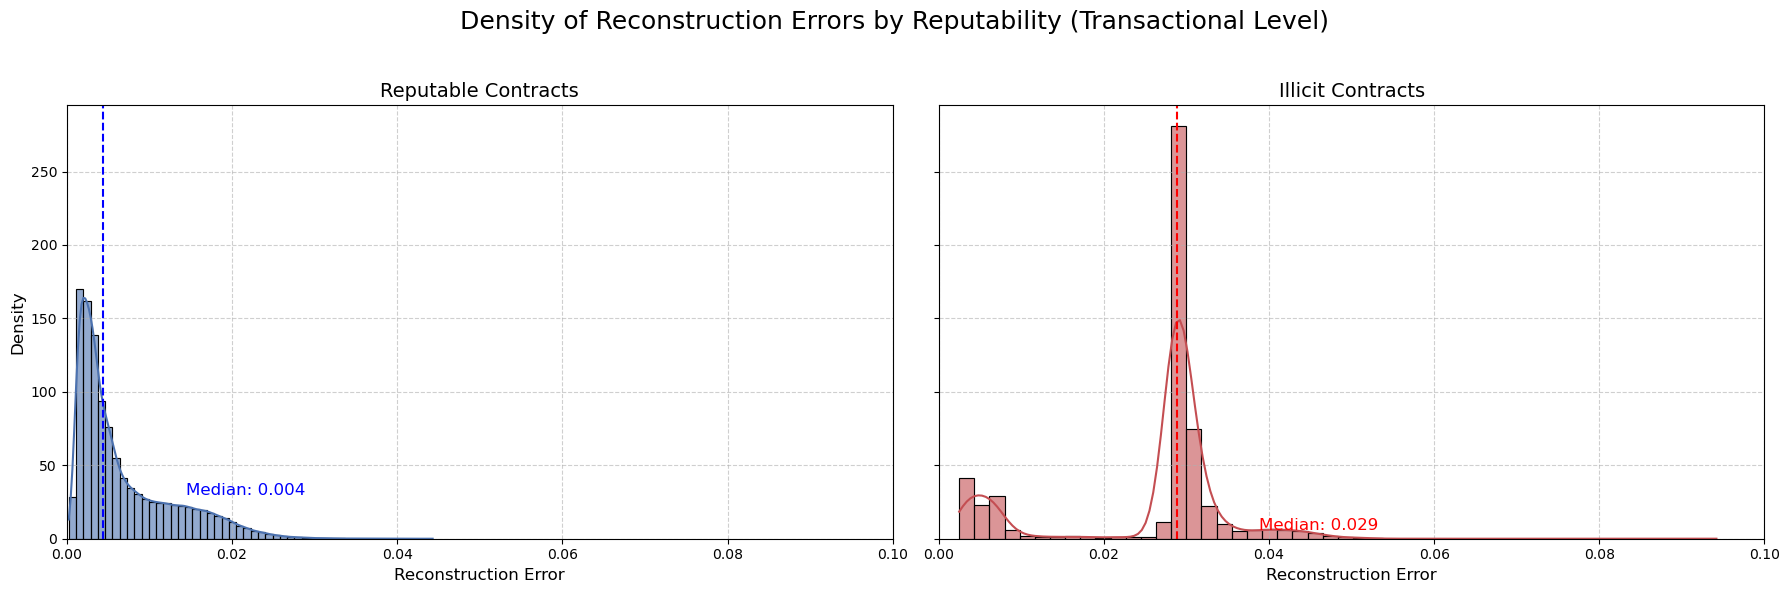

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate median values for annotations
median_reputable = reconstruction_df[reconstruction_df['contract_status'] == 1]['reconstruction_error'].median()
median_illicit = reconstruction_df[reconstruction_df['contract_status'] == 0]['reconstruction_error'].median()

# Create two subplots: one for is_reputable=1 (reputable) and one for is_reputable=0 (illicit)
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Common x-axis limit
x_limit = (0, 0.1)  # Adjust according to your data range

# Plot for is_reputable = 1 (reputable) with density
sns.histplot(reconstruction_df[reconstruction_df['contract_status'] == 1]['reconstruction_error'], 
             bins=50, kde=True, color='#4C72B0', stat='density', ax=axes[0], alpha=0.6)
axes[0].set_title('Reputable Contracts', fontsize=14)
axes[0].set_xlabel('Reconstruction Error', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_xlim(x_limit)
axes[0].grid(True, linestyle='--', alpha=0.6)

# Annotate median
axes[0].axvline(median_reputable, color='blue', linestyle='--')
axes[0].text(median_reputable + 0.01, 30, f'Median: {median_reputable:.3f}', color='blue', fontsize=12)

# Plot for is_reputable = 0 (illicit) with density
sns.histplot(reconstruction_df[reconstruction_df['contract_status'] == 0]['reconstruction_error'], 
             bins=50, kde=True, color='#C44E52', stat='density', ax=axes[1], alpha=0.6)
axes[1].set_title('Illicit Contracts', fontsize=14)
axes[1].set_xlabel('Reconstruction Error', fontsize=12)
axes[1].set_xlim(x_limit)
axes[1].grid(True, linestyle='--', alpha=0.6)

# Annotate median
axes[1].axvline(median_illicit, color='red', linestyle='--')
axes[1].text(median_illicit + 0.01, 6, f'Median: {median_illicit:.3f}', color='red', fontsize=12)

# Set a common title and adjust layout
fig.suptitle('Density of Reconstruction Errors by Reputability (Transactional Level)', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
plt.show()


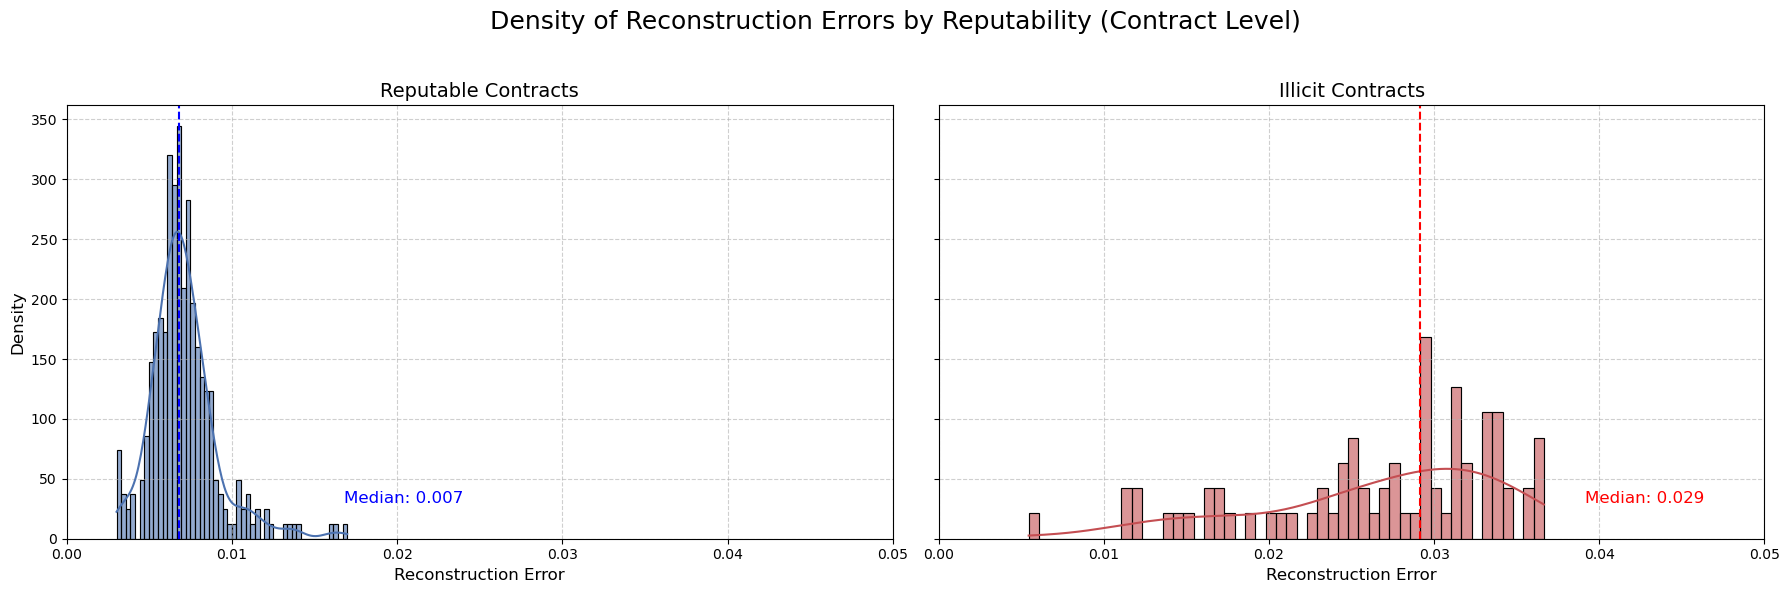

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

contract_df = reconstruction_df.groupby('address').agg({
    'reconstruction_error': 'mean',  # Mean reconstruction error per contract
    'contract_status': 'first'       # Take the first value of contract_status (since it's consistent within each address)
}).reset_index()
# Calculate median values for annotations
median_reputable = contract_df[contract_df['contract_status'] == 1]['reconstruction_error'].median()
median_illicit = contract_df[contract_df['contract_status'] == 0]['reconstruction_error'].median()

# Create two subplots: one for is_reputable=1 (reputable) and one for is_reputable=0 (illicit)
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Common x-axis limit
x_limit = (0, 0.05)  # Adjust according to your data range

# Plot for is_reputable = 1 (reputable) with density
sns.histplot(contract_df[contract_df['contract_status'] == 1]['reconstruction_error'], 
             bins=50, kde=True, color='#4C72B0', stat='density', ax=axes[0], alpha=0.6)
axes[0].set_title('Reputable Contracts', fontsize=14)
axes[0].set_xlabel('Reconstruction Error', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_xlim(x_limit)
axes[0].grid(True, linestyle='--', alpha=0.6)

# Annotate median
axes[0].axvline(median_reputable, color='blue', linestyle='--')
axes[0].text(median_reputable + 0.01, 30, f'Median: {median_reputable:.3f}', color='blue', fontsize=12)


# Plot for is_reputable = 0 (illicit) with density
sns.histplot(contract_df[contract_df['contract_status'] == 0]['reconstruction_error'], 
             bins=50, kde=True, color='#C44E52', stat='density', ax=axes[1], alpha=0.6)
axes[1].set_title('Illicit Contracts', fontsize=14)
axes[1].set_xlabel('Reconstruction Error', fontsize=12)
axes[1].set_xlim(x_limit)
axes[1].grid(True, linestyle='--', alpha=0.6)

# Annotate median
axes[1].axvline(median_illicit, color='red', linestyle='--')
axes[1].text(median_illicit + 0.01, 30, f'Median: {median_illicit:.3f}', color='red', fontsize=12)

# Set a common title and adjust layout
fig.suptitle('Density of Reconstruction Errors by Reputability (Contract Level)', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
plt.show()


# K Fold Cross Validation

In [12]:
X_combined = np.concatenate([X_rep, X_ill], axis=0)
addresses_combined = np.concatenate([addresses_rep, addresses_ill], axis=0)
labels_combined = np.concatenate([np.ones(X_rep.shape[0]), np.zeros(X_ill.shape[0])], axis=0)  # 1 for reputable, 0 for illicit
# X_combined = X_combined.get()

1116/1116 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Shape of 2D latent representations: (35690, 144)


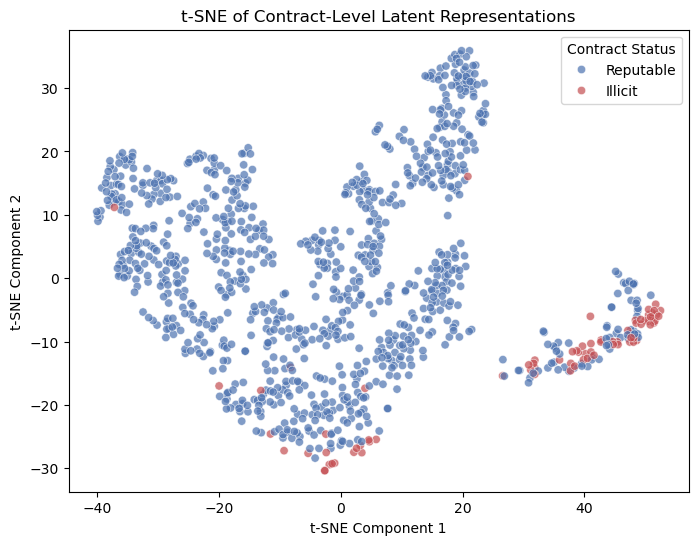

In [13]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the latent representations (bottleneck layer output)
# Define a new model to extract the latent space from the autoencoder
latent_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer("max_pooling1d_1").output) # bottleneck layer 

# Get latent representations for the entire dataset
latent_representations = latent_model.predict(X_combined)

latent_representations_2d = latent_representations.reshape(latent_representations.shape[0], -1)

# Check the shape to ensure it's 2D
print("Shape of 2D latent representations:", latent_representations_2d.shape)

# Assuming `transaction_labels` contains contract addresses for each transaction
# Convert transaction_labels to a DataFrame to handle grouping
transaction_df = pd.DataFrame({
    'latent': list(latent_representations_2d),
    'contract_address': addresses_combined
})

label_mapping = {1.0: 'Reputable', 0.0: 'Illicit'}
# Calculate the mean representation for each contract
latent_representations_contract = transaction_df.groupby('contract_address')['latent'].apply(np.mean).tolist()
latent_representations_contract = np.array(latent_representations_contract)

# Generate contract-level labels (assuming `labels_combined` has a label per transaction)
# Here, contract_labels should contain a single label per contract.
contract_labels = pd.Series(labels_combined).groupby(addresses_combined).first().values
contract_labels_named = pd.Series(contract_labels).map(label_mapping)

# Apply PCA to contract-level representations
tsne = TSNE(n_components=2)
latent_tsne_contract = tsne.fit_transform(latent_representations_contract)

# Create a mapping from numerical labels to descriptive labels
label_mapping = {1.0: 'Reputable', 0.0: 'Illicit'}
contract_labels_named = pd.Series(contract_labels).map(label_mapping)

# Plot PCA for contracts
plt.figure(figsize=(8, 6))
sns.scatterplot(x=latent_tsne_contract[:, 0], y=latent_tsne_contract[:, 1], hue=contract_labels_named, alpha=0.7,
                palette={'Reputable': '#4C72B0', 'Illicit': '#C44E52'})
plt.title('t-SNE of Contract-Level Latent Representations')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Contract Status')
plt.show()

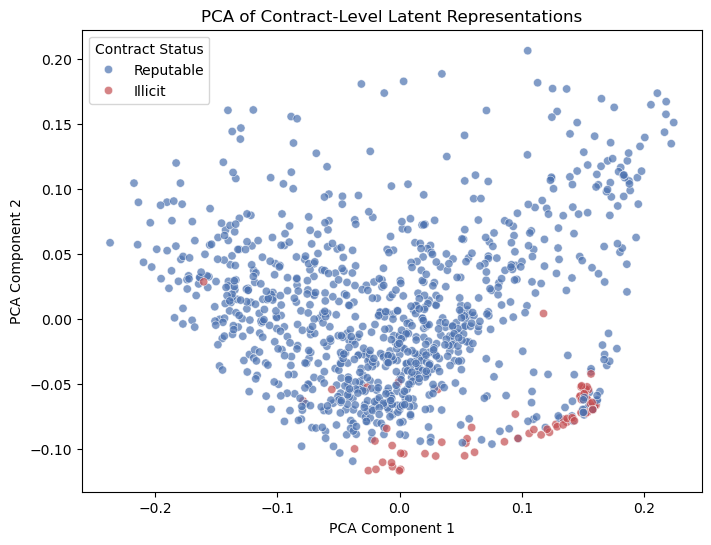

: 

In [14]:
# Apply PCA to contract-level representations
pca = PCA(n_components=2)
latent_pca_contract = pca.fit_transform(latent_representations_contract)

# Create a mapping from numerical labels to descriptive labels
label_mapping = {1.0: 'Reputable', 0.0: 'Illicit'}
contract_labels_named = pd.Series(contract_labels).map(label_mapping)

# Plot PCA for contracts
plt.figure(figsize=(8, 6))
sns.scatterplot(x=latent_pca_contract[:, 0], y=latent_pca_contract[:, 1], hue=contract_labels_named, alpha=0.7,
                palette={'Reputable': '#4C72B0', 'Illicit': '#C44E52'})
plt.title('PCA of Contract-Level Latent Representations')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Contract Status')
plt.show()

In [24]:
X_combined.shape

(35690, 24, 79)

In [3]:
rep_df = pd.read_csv("../transactions/reputable_transactions_H.csv")
rep_df['address'] = rep_df['address'].str.lower()

# Select only the continuous variables from the provided columns
continuous_cols = rep_df.drop(columns=['address', 'avg_min_between_received_tnx_missing',
                                   'avg_min_between_sent_tnx_missing', 'timeStamp'],
                                   axis=1).columns

# Now, remove outliers from only the continuous variables
for col in continuous_cols:
    Q1 = rep_df[col].quantile(0.25)
    Q3 = rep_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    rep_df = rep_df[(rep_df[col] >= lower_bound) & (rep_df[col] <= upper_bound)]

# Reset index and display the cleaned DataFrame
rep_df.reset_index(drop=True, inplace=True)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
rep_df[rep_df.drop(columns=["address", "timeStamp"]).columns] = scaler.fit_transform(rep_df[rep_df.drop(columns=["address", "timeStamp"]).columns])

ill_df = pd.read_csv("../transactions/illicit_transactions_H.csv")
ill_df['address'] = ill_df['address'].str.lower()
ill_df[ill_df.drop(columns=["address", "timeStamp"]).columns] = scaler.fit_transform(ill_df[ill_df.drop(columns=["address", "timeStamp"]).columns])

In [4]:
rep_df

,address,timeStamp,transaction_count_sent,total_value_sent,avg_value_sent,min_value_sent,max_value_sent,gas_sum_sent,gas_mean_sent,gasPrice_sum_sent,...,gas_mean_received,gasPrice_sum_received,gasUsed_sum_received,gasUsed_mean_received,error_count_received,unique_contracts_interacted_with_received,avg_min_between_received_tnx,time_diff_between_first_and_last,avg_min_between_sent_tnx_missing,avg_min_between_received_tnx_missing
0,0x006bea43baa3f7a6f765f14f10a1a1b08334ef45,2017-08-01 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.292691,0.087500,0.0,0.0,0.0,0.0,1.000000,0.010513,0.0,1.0
1,0x006bea43baa3f7a6f765f14f10a1a1b08334ef45,2017-08-04 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.240418,0.441666,0.0,0.0,0.0,0.0,0.006956,0.010513,0.0,0.0
2,0x006bea43baa3f7a6f765f14f10a1a1b08334ef45,2017-08-04 07:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.851953,0.120833,0.0,0.0,0.0,0.0,0.004878,0.010513,0.0,0.0
3,0x006bea43baa3f7a6f765f14f10a1a1b08334ef45,2017-08-07 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.286267,0.212500,0.0,0.0,0.0,0.0,0.029479,0.010513,0.0,0.0
4,0x006bea43baa3f7a6f765f14f10a1a1b08334ef45,2017-08-07 07:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.635767,0.087500,0.0,0.0,0.0,0.0,1.000000,0.010513,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820915,0xffe203b59393593965842439ce1e7d7c78109b46,2024-02-19 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.076703,0.177417,0.0,0.0,0.0,0.0,0.000417,0.182963,0.0,0.0
820916,0xffe203b59393593965842439ce1e7d7c78109b46,2024-02-19 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.508242,0.274063,0.0,0.0,0.0,0.0,0.015278,0.182963,0.0,0.0
820917,0xffe203b59393593965842439ce1e7d7c78109b46,2024-02-19 07:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.235867,0.106570,0.0,0.0,0.0,0.0,1.000000,0.182963,0.0,1.0
820918,0xffe203b59393593965842439ce1e7d7c78109b46,2024-02-19 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.323095,0.130356,0.0,0.0,0.0,0.0,1.000000,0.182963,0.0,1.0


In [5]:
ill_df

,address,timeStamp,transaction_count_sent,total_value_sent,avg_value_sent,min_value_sent,max_value_sent,gas_sum_sent,gas_mean_sent,gasPrice_sum_sent,...,gas_mean_received,gasPrice_sum_received,gasUsed_sum_received,gasUsed_mean_received,error_count_received,unique_contracts_interacted_with_received,avg_min_between_received_tnx,time_diff_between_first_and_last,avg_min_between_sent_tnx_missing,avg_min_between_received_tnx_missing
0,0x02fd82cba3bae39484d5eb7f75b5f3d5f418c691,2017-12-05 14:00:00,0.012658,0.000000,0.000000,0.000000,0.000000,0.341079,0.831245,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,1.000000,0.166178,1.0,1.0
1,0x02fd82cba3bae39484d5eb7f75b5f3d5f418c691,2017-12-10 00:00:00,0.025316,0.001271,0.000710,0.000710,0.000700,0.000518,0.000632,0.0,...,0.010144,0.000074,0.0,0.0,0.000258,0.0,0.002514,0.166178,0.0,0.0
2,0x02fd82cba3bae39484d5eb7f75b5f3d5f418c691,2017-12-10 21:00:00,0.025316,0.002725,0.001521,0.001014,0.002000,0.000518,0.000632,0.0,...,0.020000,0.000074,0.0,0.0,0.000000,0.0,0.001218,0.166178,0.0,0.0
3,0x02fd82cba3bae39484d5eb7f75b5f3d5f418c691,2017-12-12 01:00:00,0.012658,0.000108,0.000121,0.000121,0.000119,0.000259,0.000632,0.0,...,0.013333,0.000002,0.0,0.0,0.000000,0.0,1.000000,0.166178,1.0,1.0
4,0x02fd82cba3bae39484d5eb7f75b5f3d5f418c691,2017-12-12 18:00:00,0.012658,0.000082,0.000091,0.000091,0.000090,0.000259,0.000632,0.0,...,0.004765,0.000029,0.0,0.0,0.000000,0.0,1.000000,0.166178,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6756,0xfad05ee13c8e0ec94e5ee9dc056dc451b2ad6b1d,2024-03-19 14:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.003775,0.000045,0.0,0.0,0.000517,0.0,0.005517,1.000000,1.0,0.0
6757,0xfad05ee13c8e0ec94e5ee9dc056dc451b2ad6b1d,2024-05-22 19:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.013133,0.000005,0.0,0.0,0.000000,0.0,1.000000,1.000000,1.0,1.0
6758,0xfad05ee13c8e0ec94e5ee9dc056dc451b2ad6b1d,2024-06-22 19:00:00,0.012658,0.000007,0.000008,0.000008,0.000008,0.000259,0.000632,0.0,...,0.003860,0.000001,0.0,0.0,0.000000,0.0,1.000000,1.000000,1.0,1.0
6759,0xfad05ee13c8e0ec94e5ee9dc056dc451b2ad6b1d,2024-06-23 06:00:00,0.025316,0.000963,0.000537,0.000459,0.000607,0.000518,0.000632,0.0,...,0.003942,0.000002,0.0,0.0,0.000517,0.0,0.003850,1.000000,0.0,0.0


In [30]:
transaction_error_df

,address,transaction_index,reconstruction_error,contract_status
0,0x006bea43baa3f7a6f765f14f10a1a1b08334ef45,0,0.005143,0.0
1,0x006bea43baa3f7a6f765f14f10a1a1b08334ef45,1,0.026113,0.0
2,0x006bea43baa3f7a6f765f14f10a1a1b08334ef45,2,0.020836,0.0
3,0x006bea43baa3f7a6f765f14f10a1a1b08334ef45,3,0.012602,0.0
4,0x006bea43baa3f7a6f765f14f10a1a1b08334ef45,4,0.005800,0.0
...,...,...,...,...
843916,0xfad05ee13c8e0ec94e5ee9dc056dc451b2ad6b1d,4,0.045256,1.0
843917,0xfad05ee13c8e0ec94e5ee9dc056dc451b2ad6b1d,5,0.036975,1.0
843918,0xfad05ee13c8e0ec94e5ee9dc056dc451b2ad6b1d,6,0.037098,1.0
843919,0xfad05ee13c8e0ec94e5ee9dc056dc451b2ad6b1d,7,0.020182,1.0


In [22]:
X_rep.shape

(35159, 24, 79)

In [18]:
from sklearn.model_selection import GroupKFold
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Number of folds for cross-validation
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Assuming transaction_error_df contains 'address', 'reconstruction_error', and 'contract_status'

# Get labels and groups (addresses) for GroupKFold
labels = transaction_error_df['contract_status'].values  # 1 for illicit, 0 for reputable
groups = transaction_error_df['address'].values

# Lists to store results for each fold
fold_results = []

# Iterate through each fold, based on contract grouping
for fold, (train_index, val_index) in enumerate(gkf.split(transaction_error_df, labels, groups), 1):
    print(f"Processing fold {fold}/{n_splits}...")

    # Training and validation data based on grouped contract addresses
    train_data = transaction_error_df.iloc[train_index]
    val_data = transaction_error_df.iloc[val_index]
    
    # Train model on reputable contracts only (assuming 0 is reputable)
    X_train_reputable = train_data[train_data['contract_status'] == 1]
    
    # Load and fit model (assuming autoencoder is pre-defined)
    model = tf.keras.models.load_model("X_train_reputable.keras")
    model.fit(X_train_reputable, X_train_reputable, epochs=30, batch_size=64, verbose=0)
    
    # Predict reconstruction on the validation set
    X_val_seq = val_data['reconstruction_error'].values.reshape(-1, 1)
    reconstructed_X_val = model.predict(X_val_seq)
    
    # Calculate reconstruction errors for the validation set
    val_data['predicted_reconstruction_error'] = reconstructed_X_val.flatten()
    
    # Calculate transaction-level anomaly status
    val_data['is_anomalous'] = (val_data['predicted_reconstruction_error'] > best_transaction_threshold).astype(int)
    
    # Calculate contract-level anomaly scores
    contract_anomaly_scores = val_data.groupby('address')['is_anomalous'].mean()
    
    # Classify contracts using the best contract threshold
    predicted_illicit = (contract_anomaly_scores > best_contract_threshold).astype(int)
    
    # Merge with actual labels for evaluation
    results_df = pd.DataFrame({
        'address': contract_anomaly_scores.index,
        'anomaly_score': contract_anomaly_scores.values,
        'predicted_illicit': predicted_illicit,
        'actual_illicit': val_data.groupby('address')['contract_status'].first().values
    })
    
    # Calculate evaluation metrics for the current fold
    fold_metrics = {
        'Fold': fold,
        'Accuracy': accuracy_score(results_df['actual_illicit'], results_df['predicted_illicit']),
        'Precision': precision_score(results_df['actual_illicit'], results_df['predicted_illicit']),
        'Recall': recall_score(results_df['actual_illicit'], results_df['predicted_illicit']),
        'F1-Score': f1_score(results_df['actual_illicit'], results_df['predicted_illicit']),
        'AUC Score': roc_auc_score(results_df['actual_illicit'], results_df['anomaly_score']),
        'Illicit Recall': recall_score(results_df['actual_illicit'], results_df['predicted_illicit']),
        'Confusion Matrix': confusion_matrix(results_df['actual_illicit'], results_df['predicted_illicit']).tolist()
    }
    
    # Store the metrics for the fold
    fold_results.append(fold_metrics)

# Convert fold results to DataFrame for easier analysis
fold_results_df = pd.DataFrame(fold_results)

# Output the mean and standard deviation of metrics across folds
mean_results = fold_results_df.mean(numeric_only=True)
std_results = fold_results_df.std(numeric_only=True)

print("K-Fold Cross-Validation Results:")
print(f"Mean Accuracy: {mean_results['Accuracy']:.4f} ± {std_results['Accuracy']:.4f}")
print(f"Mean Precision: {mean_results['Precision']:.4f} ± {std_results['Precision']:.4f}")
print(f"Mean Recall: {mean_results['Recall']:.4f} ± {std_results['Recall']:.4f}")
print(f"Mean F1-Score: {mean_results['F1-Score']:.4f} ± {std_results['F1-Score']:.4f}")
print(f"Mean AUC Score: {mean_results['AUC Score']:.4f} ± {std_results['AUC Score']:.4f}")
print(f"Mean Recall for Illicit Contracts: {mean_results['Illicit Recall']:.4f} ± {std_results['Illicit Recall']:.4f}")

# Save the fold results for later analysis or reporting
fold_results_df.to_csv("cross_validation_results_opcode.csv", index=False)

# Show detailed metrics for each fold
print("\nDetailed Metrics for Each Fold:")
print(fold_results_df.to_string(index=False))

Processing fold 1/5...


/home/malikcyrus/anaconda3/envs/multimodal-env/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, 1), dtype=float32). Expected shape (None, 24, 79), but input has incompatible shape (None, 1)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(None, 1), dtype=float32)
  • training=True
  • mask=None

In [42]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
best_transaction_threshold = np.percentile(transaction_error_df['reconstruction_error'], 85)
best_contract_threshold = 0.5

# Step 1: Calculate transaction-level anomaly status using the best transaction threshold
transaction_error_df['is_anomalous'] = transaction_error_df['reconstruction_error'] > best_transaction_threshold

# Step 2: Calculate contract-level anomaly scores
contract_anomaly_scores = transaction_error_df.groupby('address')['is_anomalous'].mean()

# Step 3: Classify contracts using the best contract threshold
predicted_illicit = contract_anomaly_scores > best_contract_threshold

# Step 4: Merge with the actual labels for evaluation
results_df = pd.DataFrame({
    'address': contract_anomaly_scores.index,
    'anomaly_score': contract_anomaly_scores.values,
    'predicted_illicit': predicted_illicit,
    'actual_illicit': transaction_error_df.groupby('address')['contract_status'].first()
})

# Step 5: Generate evaluation metrics
# Confusion Matrix
conf_matrix = confusion_matrix(results_df['actual_illicit'], results_df['predicted_illicit'])

# Classification Report
class_report = classification_report(results_df['actual_illicit'], results_df['predicted_illicit'], digits=4)

# Accuracy, Precision, Recall, F1-Score
accuracy = accuracy_score(results_df['actual_illicit'], results_df['predicted_illicit'])
precision = precision_score(results_df['actual_illicit'], results_df['predicted_illicit'])
recall = recall_score(results_df['actual_illicit'], results_df['predicted_illicit'])
f1 = f1_score(results_df['actual_illicit'], results_df['predicted_illicit'])

# AUC Score (Using the continuous anomaly score)
auc = roc_auc_score(results_df['actual_illicit'], results_df['anomaly_score'])

# Step 6: Output the evaluation metrics
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC Score: {auc:.4f}")


Confusion Matrix:
 [[922  45]
 [  1  75]]

Classification Report:
               precision    recall  f1-score   support

         0.0     0.9989    0.9535    0.9757       967
         1.0     0.6250    0.9868    0.7653        76

    accuracy                         0.9559      1043
   macro avg     0.8120    0.9702    0.8705      1043
weighted avg     0.9717    0.9559    0.9603      1043

Accuracy: 0.9559
Precision: 0.6250
Recall: 0.9868
F1-Score: 0.7653
AUC Score: 0.9847


In [10]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
contracts_df = pd.DataFrame({'address': addresses_combined, 'label': labels_combined})
contract_labels = contracts_df.groupby('address')['label'].first().values
unique_addresses = contracts_df['address'].unique()

# Number of folds for cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store results for each fold
fold_results = []

# Iterate through each fold
for fold, (train_contract_idx, val_contract_idx) in enumerate(skf.split(unique_addresses, contract_labels), 1):
    print(f"Processing fold {fold}/{n_splits}...")
    
    # Get contract addresses for training and validation
    train_addresses = unique_addresses[train_contract_idx]
    val_addresses = unique_addresses[val_contract_idx]
    
    # Assign transactions to train and validation based on contract addresses
    train_mask = np.isin(addresses_combined, train_addresses)
    val_mask = np.isin(addresses_combined, val_addresses)
    
    # Split data into training and validation sets
    X_train, X_val = X_combined[train_mask], X_combined[val_mask]
    y_train, y_val = labels_combined[train_mask], labels_combined[val_mask]
    addresses_train, addresses_val = addresses_combined[train_mask], addresses_combined[val_mask]
    
    # Train model on reputable contracts only (assuming 1 is reputable)
    X_train_reputable = X_train[y_train == 1]
    
    # Load and fit model (assuming autoencoder is pre-defined)
    model = tf.keras.models.load_model("cae_tnx_opcode_64.keras")
    model.fit(X_train_reputable, X_train_reputable, epochs=30, batch_size=64, verbose=0)
    
    # Predict reconstruction on the validation set
    reconstructed_X_val = model.predict(X_val)
    
    # Calculate reconstruction errors for the validation set
    transaction_errors = []
    for i in range(X_val.shape[0]):
        address = addresses_val[i]  # Get the corresponding address
        original_sequence = X_val[i]
        reconstructed_sequence = reconstructed_X_val[i]
        
        # Calculate MSE for each transaction within the contract
        for j in range(original_sequence.shape[0]):
            if np.all(original_sequence[j] == 0):  # Skip padded transactions
                continue
            transaction_error = np.mean(np.square(original_sequence[j] - reconstructed_sequence[j]))
            transaction_errors.append({
                'address': address,
                'transaction_index': j,
                'reconstruction_error': transaction_error,
                'contract_status': 1 - y_val[i]  # 1 for illicit, 0 for reputable
            })
    
    # Convert to DataFrame
    transaction_error_df = pd.DataFrame(transaction_errors)
    
    # Step 1: Calculate transaction-level anomaly status using the fixed transaction threshold
    transaction_error_df['is_anomalous'] = transaction_error_df['reconstruction_error'] > 0.5

    # Step 2: Calculate contract-level anomaly scores
    contract_anomaly_scores = transaction_error_df.groupby('address')['is_anomalous'].mean()

    # Step 3: Classify contracts using the fixed contract threshold
    predicted_illicit = contract_anomaly_scores > 0.5

    # Step 4: Merge with the actual labels for evaluation
    results_df = pd.DataFrame({
        'address': contract_anomaly_scores.index,
        'anomaly_score': contract_anomaly_scores.values,
        'predicted_illicit': predicted_illicit,
        'actual_illicit': transaction_error_df.groupby('address')['contract_status'].first()
    })
    
    # Calculate evaluation metrics for the current fold
    fold_metrics = {
        'Fold': fold,
        'Transaction Threshold (Percentile)': 85,
        'Contract Threshold': 0.5,
        'Accuracy': accuracy_score(results_df['actual_illicit'], results_df['predicted_illicit']),
        'Precision': precision_score(results_df['actual_illicit'], results_df['predicted_illicit']),
        'Recall': recall_score(results_df['actual_illicit'], results_df['predicted_illicit']),
        'F1-Score': f1_score(results_df['actual_illicit'], results_df['predicted_illicit']),
        'AUC Score': roc_auc_score(results_df['actual_illicit'], results_df['anomaly_score']),
        'Illicit Recall': recall_score(results_df['actual_illicit'], results_df['predicted_illicit']),
        'Confusion Matrix': confusion_matrix(results_df['actual_illicit'], results_df['predicted_illicit']).tolist()
    }
    
    # Store the metrics for the fold
    fold_results.append(fold_metrics)

# Convert fold results to DataFrame for easier analysis
fold_results_df = pd.DataFrame(fold_results)

# Output the mean and standard deviation of metrics across folds
mean_results = fold_results_df.mean(numeric_only=True)
std_results = fold_results_df.std(numeric_only=True)

print("K-Fold Cross-Validation Results:")
print(f"Mean Accuracy: {mean_results['Accuracy']:.4f} ± {std_results['Accuracy']:.4f}")
print(f"Mean Precision: {mean_results['Precision']:.4f} ± {std_results['Precision']:.4f}")
print(f"Mean Recall: {mean_results['Recall']:.4f} ± {std_results['Recall']:.4f}")
print(f"Mean F1-Score: {mean_results['F1-Score']:.4f} ± {std_results['F1-Score']:.4f}")
print(f"Mean AUC Score: {mean_results['AUC Score']:.4f} ± {std_results['AUC Score']:.4f}")
print(f"Mean Recall for Illicit Contracts: {mean_results['Illicit Recall']:.4f} ± {std_results['Illicit Recall']:.4f}")

# Save the fold results for later analysis or reporting
fold_results_df.to_csv("cross_validation_results_opcode.csv", index=False)

# Show detailed metrics for each fold
print("\nDetailed Metrics for Each Fold:")
print(fold_results_df.to_string(index=False))

Processing fold 1/5...


/home/malikcyrus/anaconda3/envs/multimodal-env/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
I0000 00:00:1727522991.242992  146109 service.cc:146] XLA service 0x7f0c4c004f30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727522991.243049  146109 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-09-28 13:29:51.308998: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-28 13:29:51.519109: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1727522994.260330  146109 device_compiler.h:188] Compiled cluster using XLA

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/malikcyrus/anaconda3/envs/multimodal-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing fold 2/5...


/home/malikcyrus/anaconda3/envs/multimodal-env/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/malikcyrus/anaconda3/envs/multimodal-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing fold 3/5...


/home/malikcyrus/anaconda3/envs/multimodal-env/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/malikcyrus/anaconda3/envs/multimodal-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing fold 4/5...


/home/malikcyrus/anaconda3/envs/multimodal-env/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/malikcyrus/anaconda3/envs/multimodal-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing fold 5/5...


/home/malikcyrus/anaconda3/envs/multimodal-env/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
K-Fold Cross-Validation Results:
Mean Accuracy: 0.9272 ± 0.0118
Mean Precision: 0.0000 ± 0.0000
Mean Recall: 0.0000 ± 0.0000
Mean F1-Score: 0.0000 ± 0.0000
Mean AUC Score: 0.5000 ± 0.0000
Mean Recall for Illicit Contracts: 0.0000 ± 0.0000

Detailed Metrics for Each Fold:
 Fold  Transaction Threshold (Percentile)  Contract Threshold  Accuracy  Precision  Recall  F1-Score  AUC Score  Illicit Recall    Confusion Matrix
    1                                  85                 0.5  0.918660        0.0     0.0       0.0        0.5             0.0 [[192, 0], [17, 0]]
    2                                  85                 0.5  0.918660        0.0     0.0       0.0        0.5             0.0 [[192, 0], [17, 0]]
    3                                  85                 0.5  0.918660        0.0     0.0       0.0        0.5             0.0 [[192, 0], [17, 0]]
    4                                  85                 0.5  0.942308        0.0     0.0     

/home/malikcyrus/anaconda3/envs/multimodal-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the latent representations (bottleneck layer output)
# Define a new model to extract the latent space from the autoencoder
latent_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer("max_pooling1d_1").output) # bottleneck layer 

# Get latent representations for the entire dataset
latent_representations = latent_model.predict(X_combined)

# Apply t-SNE for 2D visualization
tsne = TSNE(n_components=2, random_state=42)
latent_tsne = tsne.fit_transform(latent_representations)

# Apply PCA for 2D visualization (alternative to t-SNE)
pca = PCA(n_components=2)
latent_pca = pca.fit_transform(latent_representations)


# Plot t-SNE
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=latent_tsne[:, 0], y=latent_tsne[:, 1], hue=labels_binary, palette=['blue', 'red'])
plt.title('t-SNE of Latent Representations')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Plot PCA
plt.subplot(1, 2, 2)
sns.scatterplot(x=latent_pca[:, 0], y=latent_pca[:, 1], hue=labels_binary, palette=['blue', 'red'])
plt.title('PCA of Latent Representations')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.tight_layout()
plt.show()

1116/1116 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


ValueError: Found array with dim 3. TSNE expected <= 2.

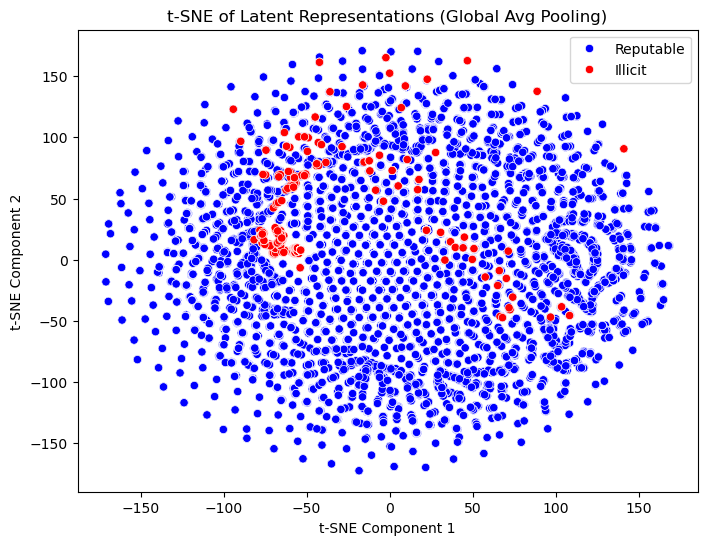

In [19]:
from tensorflow.keras.layers import GlobalAveragePooling1D

# Apply Global Average Pooling to reduce 3D to 2D (samples, features)
latent_representations_2d = GlobalAveragePooling1D()(latent_representations).numpy()

# Apply t-SNE for 2D visualization
tsne = TSNE(n_components=2, random_state=42)    
latent_tsne = tsne.fit_transform(latent_representations_2d)


# Number of samples in each dataset
num_rep = X_rep.shape[0]
num_ill = X_ill.shape[0]

# Create labels: 1 for reputable (X_rep), 0 for illicit (X_ill)
labels_rep = np.ones(num_rep, dtype=int)  # Label 1 for reputable
labels_ill = np.zeros(num_ill, dtype=int)  # Label 0 for illicit

# Concatenate the labels to match X_combined
labels_binary = np.concatenate([labels_rep, labels_ill], axis=0)

# Convert labels to binary format (1 = illicit, 0 = reputable)
labels_binary = np.where(labels_combined == 1, 'Reputable', 'Illicit')

# Plot t-SNE
plt.figure(figsize=(8, 6))
sns.scatterplot(x=latent_tsne[:, 0], y=latent_tsne[:, 1], hue=labels_binary, palette=['blue', 'red'])
plt.title('t-SNE of Latent Representations (Global Avg Pooling)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


Shape of 2D latent representations: (35690, 96)


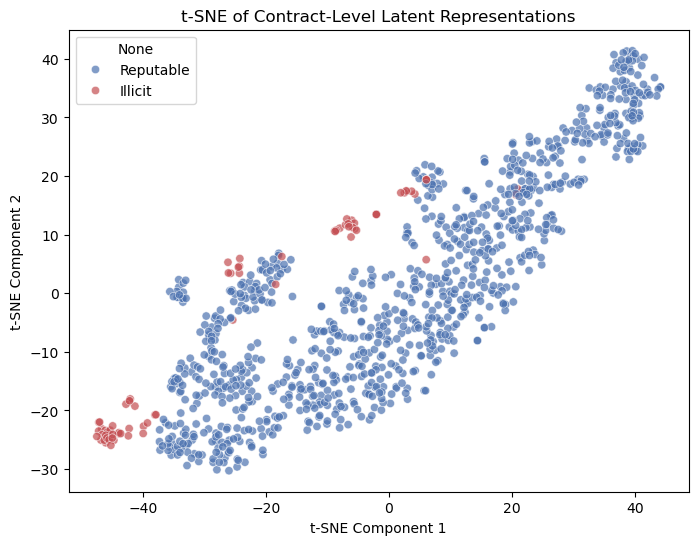

In [42]:
latent_representations_2d = latent_representations.reshape(latent_representations.shape[0], -1)

# Check the shape to ensure it's 2D
print("Shape of 2D latent representations:", latent_representations_2d.shape)

# Assuming `transaction_labels` contains contract addresses for each transaction
# Convert transaction_labels to a DataFrame to handle grouping
transaction_df = pd.DataFrame({
    'latent': list(latent_representations_2d),
    'contract_address': addresses_combined
})

label_mapping = {1.0: 'Reputable', 0.0: 'Illicit'}
# Calculate the mean representation for each contract
latent_representations_contract = transaction_df.groupby('contract_address')['latent'].apply(np.mean).tolist()
latent_representations_contract = np.array(latent_representations_contract)

# Generate contract-level labels (assuming `labels_combined` has a label per transaction)
# Here, contract_labels should contain a single label per contract.
contract_labels = pd.Series(labels_combined).groupby(addresses_combined).first().values
contract_labels_named = pd.Series(contract_labels).map(label_mapping)

# Now apply t-SNE to contract-level representations
tsne = TSNE(n_components=2, random_state=42)
latent_tsne_contract = tsne.fit_transform(latent_representations_contract)

# Plot t-SNE for contractscolors = ['#4C72B0','#C44E52'] 
plt.figure(figsize=(8, 6))
sns.scatterplot(x=latent_tsne_contract[:, 0], y=latent_tsne_contract[:, 1], hue=contract_labels_named,
                 palette={'Reputable': '#4C72B0', 'Illicit': '#C44E52'}, alpha=0.7)
plt.title('t-SNE of Contract-Level Latent Representations')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


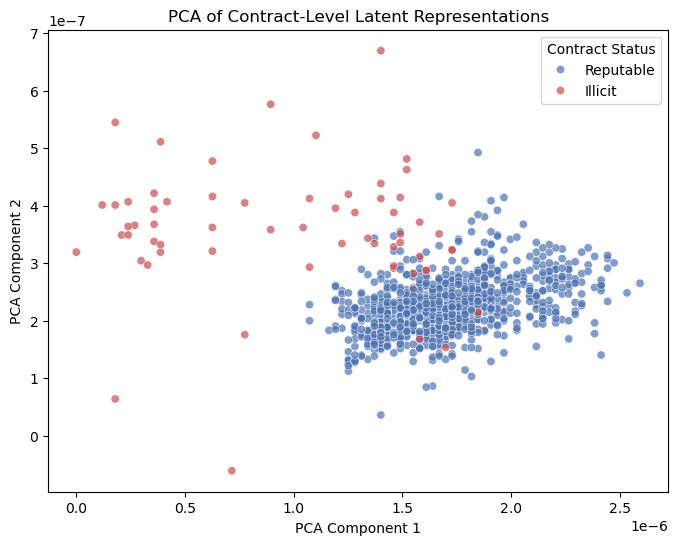

In [39]:
# Apply PCA to contract-level representations
pca = PCA(n_components=2)
latent_pca_contract = pca.fit_transform(latent_representations_contract)

# Create a mapping from numerical labels to descriptive labels
label_mapping = {1.0: 'Reputable', 0.0: 'Illicit'}
contract_labels_named = pd.Series(contract_labels).map(label_mapping)

# Plot PCA for contracts
plt.figure(figsize=(8, 6))
sns.scatterplot(x=latent_pca_contract[:, 0], y=latent_pca_contract[:, 1], hue=contract_labels_named, alpha=0.7,
                palette={'Reputable': '#4C72B0', 'Illicit': '#C44E52'})
plt.title('PCA of Contract-Level Latent Representations')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Contract Status')
plt.show()

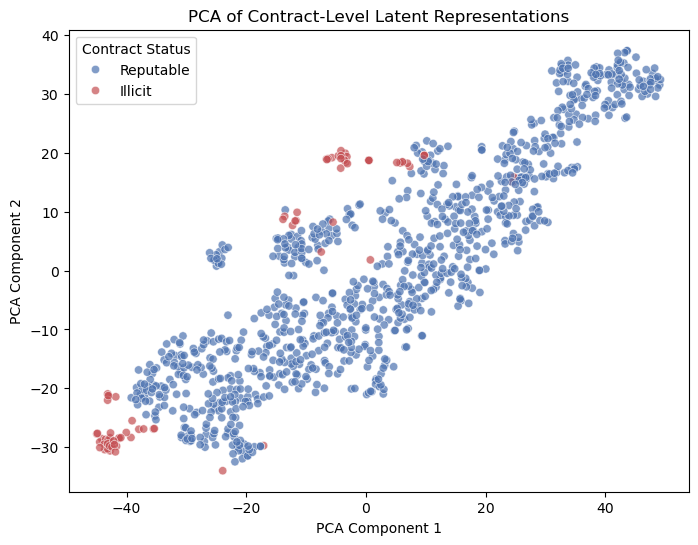

In [46]:
# Apply PCA to contract-level representations
tsne = TSNE(n_components=2)
latent_tsne_contract = tsne.fit_transform(latent_representations_contract)

# Create a mapping from numerical labels to descriptive labels
label_mapping = {1.0: 'Reputable', 0.0: 'Illicit'}
contract_labels_named = pd.Series(contract_labels).map(label_mapping)

# Plot PCA for contracts
plt.figure(figsize=(8, 6))
sns.scatterplot(x=latent_tsne_contract[:, 0], y=latent_tsne_contract[:, 1], hue=contract_labels_named, alpha=0.7,
                palette={'Reputable': '#4C72B0', 'Illicit': '#C44E52'})
plt.title('PCA of Contract-Level Latent Representations')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Contract Status')
plt.show()

In [69]:
# Number of samples in each dataset
num_rep = X_rep.shape[0]
num_ill = X_ill.shape[0]

# Create labels: 1 for reputable (X_rep), 0 for illicit (X_ill)
labels_rep = np.ones(num_rep, dtype=int)  # Label 1 for reputable
labels_ill = np.zeros(num_ill, dtype=int)  # Label 0 for illicit

# Concatenate the labels to match X_combined
labels_binary = np.concatenate([labels_rep, labels_ill], axis=0)